In [ ]:
import os

os.listdir(os.getcwd())

['.config', 'sample_data']

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/data")

In [ ]:
os.listdir(os.getcwd())

['all_data.npy',
 'train.csv',
 'sample_submission.csv',
 'data_iced_filled.npy',
 'data_iced_filled_125.npy',
 'convlstm_model2.h5',
 'convlstm_model3.h5',
 'submission04.csv',
 'convlstm_model4.h5',
 'convlstm_model5.h5',
 'convlstm_model6.h5',
 'submission05.csv',
 '124_convlstm_model.h5',
 'cropped_image_prediction.ipynb',
 'Copy of [backup]Dacon_ice_autoencoder.ipynb']

## [**EDA**]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
%matplotlib inline

In [ ]:
gc.enable()

In [ ]:
gc.garbage.clear()

In [ ]:
# path for loading data
TRAIN_CSV_PATH = "/content/drive/My Drive/data/train.csv"
SAMPLE_SUBMISSION_PATH = "/content/drive/My Drive/data/"

In [ ]:
# filenames for the image files
train_file_list = pd.read_csv(TRAIN_CSV_PATH)['file_nm'].values

### image cropping

In [ ]:
# load data
all_data_ice = np.load("all_data.npy")

In [ ]:
# use data for past 15 years only
all_data_ice = all_data_ice[-180:, :, :, 0]

In [ ]:
# check one image
one_image = all_data_ice[0, :, :]

one_image.shape

(448, 304)

In [ ]:
# max value is 250
one_image.max()

250

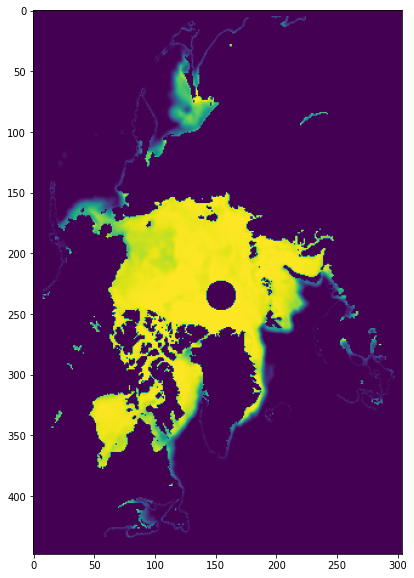

In [ ]:
# looking good
fig = plt.figure(figsize=(20, 10))
plt.imshow(one_image)
fig.show()

The approach here is to crop image into smaller images and then build a model that will fit to that smaller image. 

After prediction is done, smaller images will be recombined to create the whole image

In [ ]:
# i will set the crop size for 64 
col = 304
row = 448

crop_size = 64

# caculate greatest commone divisor to determine how much strides I can take
gcd = np.gcd((col - crop_size), (row - crop_size))
print(gcd)
print(crop_size**2)


48
4096


In [ ]:
# Set window size as 24. So this will take strides of size 24 pixels to right and bottom
# to create cropped image of 64 x 64
## this will create overlaps within images, which I will take account into when forming the bigger image
col = 304
row = 448

crop_size = 64
window_size = 24

# where cropped image will be added
# for each image, 187 cropped images are created
all_cropped_images = []

for i in range(len(all_data_ice)):
    one_image = all_data_ice[i, :, :]

    col_start = 0
    row_start = 0

    cropped_images = []

    # move right and bottom of the image to crop
    while (row_start+crop_size) <= 448:
        col_start = 0
        while (col_start+crop_size) <= 304:
            cropped_image = one_image[row_start:row_start+crop_size, col_start:col_start+crop_size]
            
            cropped_images.append(cropped_image)

            col_start += window_size
        row_start += window_size
    
    cropped_images = np.array(cropped_images)
    all_cropped_images.append(cropped_images)
  
all_cropped_images = np.array(all_cropped_images)

In [ ]:
all_cropped_images.shape

(180, 187, 64, 64)

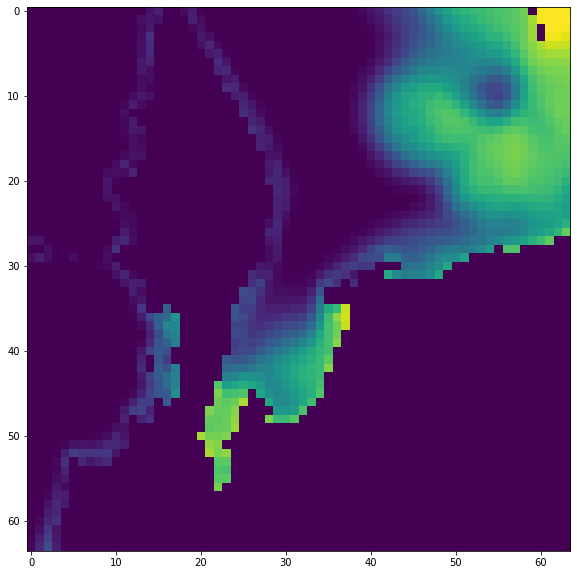

In [ ]:
# cropped image
fig = plt.figure(figsize=(10, 10))
plt.imshow(all_cropped_images[0, 36, :, :])
fig.show()

In [ ]:
# create X_train and y_train data
# we will use inputs data period of 5 years
year_period = 6

x_train = []
y_train = []

for i in range(12):
    month_data = all_cropped_images[list(range(i, 180, 12))] 

    start_year = 0
    end_year = year_period

    while end_year <= month_data.shape[0]:
      data_over_period = month_data[start_year:end_year, :, :, :]

      for i in range(month_data.shape[1]):
          images_over_period = data_over_period[:, i, :, :]
          x_data = images_over_period[0:-1, :, :]
          x_train.append(x_data)

          y_data = images_over_period[-1, :, :]
          y_train.append(y_data)

      start_year += 1
      end_year += 1



In [ ]:
# 22440 train dataset
np.array(x_train).shape

(22440, 5, 64, 64)

In [ ]:
# 22440 target datasets
np.array(y_train).shape

(22440, 64, 64)

In [ ]:
# convert in to array
x_train = np.array(x_train)
y_train = np.array(y_train)

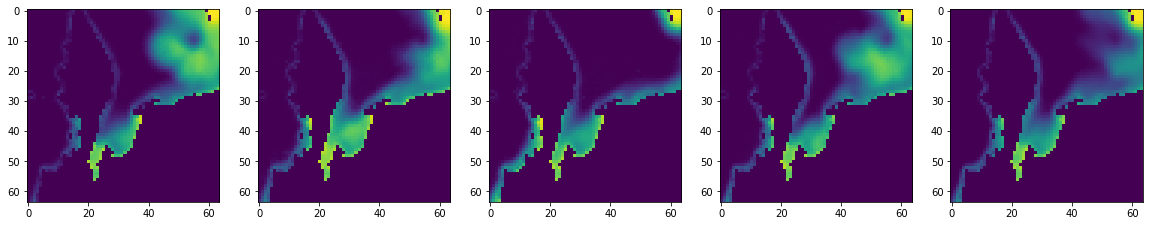

In [ ]:
# check to see one of the train data
fig = plt.figure(figsize=(20, 5))
for i in range(5):
  fig.add_subplot(1, 5, i+1)
  plt.imshow(x_train[36, i, :, :])

fig.show()

In [ ]:
# make test data
# use the most recent 5 years of our dataset

data_all_cropped_test = all_cropped_images[-60:, :, :, :]

year_period = 10

x_test = []

for i in range(12):

    month_data = data_all_cropped_test[list(range(i, 60, 12))] 

    x_test_month = []
    for i in range(month_data.shape[1]):
      images_over_period = month_data[:, i, :, :]
      x_test_month.append(images_over_period)

    x_test_month = np.array(x_test_month)
    x_test.append(x_test_month)


In [ ]:
# convert the dataset
np.array(x_test).shape

(12, 187, 5, 64, 64)

In [ ]:
# convert to np.array
x_test = np.array(x_test)

In [ ]:
# index to shuffle the data
ind_list = np.array([i for i in range(x_train.shape[0])])
np.random.shuffle(ind_list)

In [ ]:
# data shuffled
x_train = x_train[ind_list]
y_train = y_train[ind_list]

In [ ]:
x_train.shape

(22440, 5, 64, 64)

In [ ]:
# y_train will be scaled
# due to memory size, x_train will be scaled within the model
y_train = y_train / 250
x_train = x_train

In [ ]:
# split date to train and valid set
X_train, X_valid = x_train[:19000], x_train[19000:]
Y_train, Y_valid = y_train[:19000], y_train[19000:]

In [ ]:
X_train.shape

(19000, 5, 64, 64)

## Model Training

1. Three ConvLSTM2D + BatchNorm layers and Dense(64, sigmoid)  
  **Validation_loss** = 2.9500 (scaled mae 0.0118, 20 epochs)
2. Three ConvLSTM2D + BatchNorm layers and Dense(64, relu)  
  **Validation_loss** = 5.1563, 20 epochs
3. (BatchNorm + MultiHead + BatchNorm + Dense) x 2 + Dense  
  **Validation_loss** = 19.5847, 11 epochs
4. Two LSTM + BatchNorm Layers  
  **Validation_loss** = 18.3465, 6 epochs

In [ ]:
import tensorflow as tf
from tensorflow import keras

### Three ConvLSTM2D + BatchNorm layers and Dense(64, sigmoid)

In [ ]:
K = keras.backend

def mae_scaled(y_true, y_pred):
  mae = K.mean(K.abs(y_true - y_pred))
  mae_scaled = mae * 250.
  return mae_scaled

In [ ]:
input = tf.keras.Input(shape=[5, 64, 64])

x  = input / 250.

x = tf.keras.layers.Reshape(target_shape=[-1, 64, 64, 1])(x)

x = tf.keras.layers.ConvLSTM2D(64, 3, padding="same", return_sequences=True)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.ConvLSTM2D(64, 3, padding="same", return_sequences=True)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.ConvLSTM2D(64, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(1, 3, padding="same")(x)

x = tf.keras.layers.Reshape(target_shape=[64, 64])(x)
output = tf.keras.layers.Dense(64, activation= 'sigmoid')(x)

model_mth = keras.Model(inputs=input, outputs=output)

model_mth.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 64, 64)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 5, 64, 64)         0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 64, 64, 1)      0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 5, 64, 64, 64)     150016    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 64, 64, 64)     256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 5, 64, 64, 64)     295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 64, 64, 64)     256   

In [ ]:
model_mth.compile(loss="mae", optimizer=keras.optimizers.Adam())

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'convlstm_model2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model_mth.fit(X_train, Y_train, epochs=15, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks_list)

Epoch 1/15
594/594 [==============================] - 743s 1s/step - loss: 0.0997 - val_loss: 0.0367
Epoch 2/15
594/594 [==============================] - 704s 1s/step - loss: 0.0315 - val_loss: 0.0286
Epoch 3/15
594/594 [==============================] - 703s 1s/step - loss: 0.0252 - val_loss: 0.0228
Epoch 4/15
594/594 [==============================] - 703s 1s/step - loss: 0.0217 - val_loss: 0.0212
Epoch 5/15
594/594 [==============================] - 703s 1s/step - loss: 0.0209 - val_loss: 0.0199
Epoch 6/15
594/594 [==============================] - 704s 1s/step - loss: 0.0194 - val_loss: 0.0215
Epoch 7/15
594/594 [==============================] - 702s 1s/step - loss: 0.0188 - val_loss: 0.0189
Epoch 8/15
594/594 [==============================] - 703s 1s/step - loss: 0.0175 - val_loss: 0.0176
Epoch 9/15
594/594 [==============================] - 702s 1s/step - loss: 0.0171 - val_loss: 0.0168
Epoch 10/15
594/594 [==============================] - 703s 1s/step - loss: 0.0167 - val_lo

In [ ]:
model_mth = tf.keras.models.load_model("convlstm_model2.h5")

In [ ]:
model_mth = tf.keras.models.load_model("convlstm_model3.h5")

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'convlstm_model4.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model_mth.fit(X_train, Y_train, epochs=10, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks_list)

Epoch 1/10
594/594 [==============================] - 704s 1s/step - loss: 0.0123 - val_loss: 0.0127
Epoch 2/10
594/594 [==============================] - 703s 1s/step - loss: 0.0120 - val_loss: 0.0124
Epoch 3/10
594/594 [==============================] - 703s 1s/step - loss: 0.0117 - val_loss: 0.0119
Epoch 4/10
594/594 [==============================] - 703s 1s/step - loss: 0.0113 - val_loss: 0.0118
Epoch 5/10
594/594 [==============================] - 702s 1s/step - loss: 0.0111 - val_loss: 0.0120
Epoch 6/10
594/594 [==============================] - 703s 1s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 7/10
594/594 [==============================] - 703s 1s/step - loss: 0.0106 - val_loss: 0.0113
Epoch 8/10
594/594 [==============================] - 703s 1s/step - loss: 0.0105 - val_loss: 0.0110
Epoch 9/10
594/594 [==============================] - 702s 1s/step - loss: 0.0103 - val_loss: 0.0105
Epoch 10/10
594/594 [==============================] - 703s 1s/step - loss: 0.0100 - val_lo

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'convlstm_model5.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model_mth.fit(X_train, Y_train, epochs=10, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks_list)

Epoch 1/10
594/594 [==============================] - 703s 1s/step - loss: 0.0099 - val_loss: 0.0118
Epoch 2/10
594/594 [==============================] - 703s 1s/step - loss: 0.0099 - val_loss: 0.0104
Epoch 3/10
594/594 [==============================] - 703s 1s/step - loss: 0.0095 - val_loss: 0.0100
Epoch 4/10
594/594 [==============================] - 703s 1s/step - loss: 0.0095 - val_loss: 0.0100
Epoch 5/10
594/594 [==============================] - 703s 1s/step - loss: 0.0093 - val_loss: 0.0100
Epoch 6/10
594/594 [==============================] - 702s 1s/step - loss: 0.0092 - val_loss: 0.0096
Epoch 7/10
594/594 [==============================] - 702s 1s/step - loss: 0.0090 - val_loss: 0.0098
Epoch 8/10
594/594 [==============================] - 702s 1s/step - loss: 0.0090 - val_loss: 0.0096
Epoch 9/10
594/594 [==============================] - 702s 1s/step - loss: 0.0090 - val_loss: 0.0094
Epoch 10/10
594/594 [==============================] - 702s 1s/step - loss: 0.0087 - val_lo

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'convlstm_model6.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model_mth.fit(X_train, Y_train, epochs=5, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks_list)

Epoch 1/5
594/594 [==============================] - 703s 1s/step - loss: 0.0087 - val_loss: 0.0094
Epoch 2/5
594/594 [==============================] - 702s 1s/step - loss: 0.0085 - val_loss: 0.0095
Epoch 3/5
594/594 [==============================] - 703s 1s/step - loss: 0.0085 - val_loss: 0.0092
Epoch 4/5
594/594 [==============================] - 703s 1s/step - loss: 0.0085 - val_loss: 0.0091
Epoch 5/5
594/594 [==============================] - 702s 1s/step - loss: 0.0084 - val_loss: 0.0096


### Three ConvLSTM2D + BatchNorm layers and Dense(64, relu)

In [ ]:
input = tf.keras.Input(shape=[5, 64, 64])

x = input / 250.

x = tf.keras.layers.Reshape(target_shape=[-1, 64, 64, 1])(x)

x = tf.keras.layers.ConvLSTM2D(64, 3, padding="same", return_sequences=True)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.ConvLSTM2D(64, 3, padding="same", return_sequences=True)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.ConvLSTM2D(64, 3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(1, 3, padding="same")(x)

x = tf.keras.layers.Reshape(target_shape=[64, 64])(x)
output = tf.keras.layers.Dense(64, activation= 'relu')(x)

model_mth = keras.Model(inputs=input, outputs=output)

model_mth.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 5, 64, 64)]       0         
_________________________________________________________________
tf.math.truediv_10 (TFOpLamb (None, 5, 64, 64)         0         
_________________________________________________________________
reshape_78 (Reshape)         (None, 5, 64, 64, 1)      0         
_________________________________________________________________
conv_lst_m2d_43 (ConvLSTM2D) (None, 5, 64, 64, 64)     150016    
_________________________________________________________________
batch_normalization_74 (Batc (None, 5, 64, 64, 64)     256       
_________________________________________________________________
conv_lst_m2d_44 (ConvLSTM2D) (None, 5, 64, 64, 64)     295168    
_________________________________________________________________
batch_normalization_75 (Batc (None, 5, 64, 64, 64)     256

In [ ]:
model_mth.compile(loss="mae", optimizer=keras.optimizers.Adam(),
                metrics=["mean_absolute_error"])

history = model_mth.fit(X_train, Y_train, epochs=20, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid))

Epoch 1/20
260/260 [==============================] - 600s 2s/step - loss: 26.2943 - mean_absolute_error: 26.2943 - val_loss: 23.1093 - val_mean_absolute_error: 23.1093
Epoch 2/20
260/260 [==============================] - 590s 2s/step - loss: 11.7574 - mean_absolute_error: 11.7574 - val_loss: 14.3719 - val_mean_absolute_error: 14.3719
Epoch 3/20
260/260 [==============================] - 590s 2s/step - loss: 10.0528 - mean_absolute_error: 10.0528 - val_loss: 9.3697 - val_mean_absolute_error: 9.3697
Epoch 4/20
260/260 [==============================] - 590s 2s/step - loss: 8.7185 - mean_absolute_error: 8.7185 - val_loss: 8.1611 - val_mean_absolute_error: 8.1611
Epoch 5/20
260/260 [==============================] - 591s 2s/step - loss: 7.9830 - mean_absolute_error: 7.9830 - val_loss: 7.6112 - val_mean_absolute_error: 7.6112
Epoch 6/20
260/260 [==============================] - 590s 2s/step - loss: 7.3431 - mean_absolute_error: 7.3431 - val_loss: 7.4558 - val_mean_absolute_error: 7.4558


In [ ]:
model_mth.save("convlstm_model.h5")

In [ ]:
model_mth = tf.keras.models.load_model("convlstm_model.h5")

In [ ]:
history = model_mth.fit(X_train, Y_train, epochs=10, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid))

Epoch 1/10
260/260 [==============================] - 1007s 4s/step - loss: 4.9130 - mean_absolute_error: 4.9130 - val_loss: 4.8464 - val_mean_absolute_error: 4.8464
Epoch 2/10
260/260 [==============================] - 1002s 4s/step - loss: 4.7894 - mean_absolute_error: 4.7894 - val_loss: 4.5055 - val_mean_absolute_error: 4.5055
Epoch 3/10
260/260 [==============================] - 1002s 4s/step - loss: 4.6518 - mean_absolute_error: 4.6518 - val_loss: 4.4668 - val_mean_absolute_error: 4.4668
Epoch 4/10
260/260 [==============================] - 1002s 4s/step - loss: 4.5598 - mean_absolute_error: 4.5598 - val_loss: 4.4928 - val_mean_absolute_error: 4.4928
Epoch 5/10
260/260 [==============================] - 1001s 4s/step - loss: 4.5112 - mean_absolute_error: 4.5112 - val_loss: 4.5135 - val_mean_absolute_error: 4.5135
Epoch 6/10
260/260 [==============================] - 1003s 4s/step - loss: 4.4795 - mean_absolute_error: 4.4795 - val_loss: 4.3092 - val_mean_absolute_error: 4.3092
Epoc

In [ ]:
model_mth.save("convlstm_model.h5")

In [ ]:
history = model_mth.fit(X_train, Y_train, epochs=5, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid))

Epoch 1/5
260/260 [==============================] - 1006s 4s/step - loss: 4.0443 - mean_absolute_error: 4.0443 - val_loss: 4.0547 - val_mean_absolute_error: 4.0547
Epoch 2/5
260/260 [==============================] - 1003s 4s/step - loss: 3.9310 - mean_absolute_error: 3.9310 - val_loss: 3.9665 - val_mean_absolute_error: 3.9665
Epoch 3/5
260/260 [==============================] - 1004s 4s/step - loss: 3.8508 - mean_absolute_error: 3.8508 - val_loss: 3.8866 - val_mean_absolute_error: 3.8866
Epoch 4/5
260/260 [==============================] - 1003s 4s/step - loss: 3.8689 - mean_absolute_error: 3.8689 - val_loss: 3.9877 - val_mean_absolute_error: 3.9877
Epoch 5/5
260/260 [==============================] - 1004s 4s/step - loss: 3.8447 - mean_absolute_error: 3.8447 - val_loss: 4.1564 - val_mean_absolute_error: 4.1564


In [ ]:
model_mth.save("convlstm_model2.h5")

In [ ]:
model_mth = tf.keras.models.load_model("convlstm_model.h5")

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'convlstm_model2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model_mth.fit(X_train, Y_train, epochs=5, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid), callbacks=callbacks_list)

Epoch 1/5
260/260 [==============================] - 1010s 4s/step - loss: 4.0008 - mean_absolute_error: 4.0008 - val_loss: 4.1334 - val_mean_absolute_error: 4.1334
Epoch 2/5
260/260 [==============================] - 1002s 4s/step - loss: 4.0289 - mean_absolute_error: 4.0289 - val_loss: 4.0275 - val_mean_absolute_error: 4.0275
Epoch 3/5
260/260 [==============================] - 1005s 4s/step - loss: 4.0403 - mean_absolute_error: 4.0403 - val_loss: 3.9034 - val_mean_absolute_error: 3.9034
Epoch 4/5
260/260 [==============================] - 1005s 4s/step - loss: 3.8813 - mean_absolute_error: 3.8813 - val_loss: 3.8914 - val_mean_absolute_error: 3.8914
Epoch 5/5
260/260 [==============================] - 1003s 4s/step - loss: 3.7306 - mean_absolute_error: 3.7306 - val_loss: 3.7395 - val_mean_absolute_error: 3.7395


### (BatchNorm + MultiHead + BatchNorm + Dense) x 2 + Dense

In [ ]:
input = tf.keras.Input(shape=[5, 64, 64])


x = tf.keras.layers.Reshape(target_shape=[5, 4096])(input)

x = x / 250

x = tf.keras.layers.Conv1D(512, 3, padding="SAME")(x)

d_model = 512

x_1 = tf.keras.layers.BatchNormalization()(x)
x_2 = tf.keras.layers.MultiHeadAttention(8, d_model)(x_1, x_1)
x_2_2 = x_2 + x
x_3 = tf.keras.layers.BatchNormalization()(x_2_2)
x_4 = tf.keras.layers.Dense(512, activation="relu")(x_3)

for i in range(1):
  x_1_1 = x_4 + x_2_2
  x_1 = tf.keras.layers.BatchNormalization()(x_1_1)
  x_2 = tf.keras.layers.MultiHeadAttention(8, d_model)(x_1, x_1)
  x_2_2 = x_2 + x_1_1
  x_3 = tf.keras.layers.BatchNormalization()(x_2_2)
  x_4 = tf.keras.layers.Dense(512, activation="relu")(x_3)

x = tf.keras.layers.Reshape(target_shape=[-1,])(x_4)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
output = tf.keras.layers.Reshape(target_shape=[64, 64])(x)

model_mth = keras.Model(inputs=input, outputs=output)

model_mth.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5, 64, 64)]  0                                            
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 5, 4096)      0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 5, 1024)      12583936    reshape_12[0][0]                 
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 5, 1024)      4096        conv1d_4[0][0]                   
____________________________________________________________________________________________

In [ ]:
K = keras.backend

def rmse(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)

  return K.sqrt(K.mean((y_true - y_pred) ** 2))

In [ ]:
model_mth.compile(loss="mae", optimizer=keras.optimizers.Adam(),
                metrics=["mean_absolute_error"])

history = model_mth.fit(X_train, Y_train, epochs=20, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid))

Epoch 1/20
260/260 [==============================] - 45s 162ms/step - loss: 29.2183 - mean_absolute_error: 29.2183 - val_loss: 24.4384 - val_mean_absolute_error: 24.4384
Epoch 2/20
260/260 [==============================] - 41s 159ms/step - loss: 23.5055 - mean_absolute_error: 23.5055 - val_loss: 22.8821 - val_mean_absolute_error: 22.8821
Epoch 3/20
260/260 [==============================] - 41s 159ms/step - loss: 22.4431 - mean_absolute_error: 22.4431 - val_loss: 22.2419 - val_mean_absolute_error: 22.2419
Epoch 4/20
260/260 [==============================] - 41s 159ms/step - loss: 21.0470 - mean_absolute_error: 21.0470 - val_loss: 22.2651 - val_mean_absolute_error: 22.2651
Epoch 5/20
260/260 [==============================] - 41s 158ms/step - loss: 20.6640 - mean_absolute_error: 20.6640 - val_loss: 20.6905 - val_mean_absolute_error: 20.6905
Epoch 6/20
260/260 [==============================] - 41s 158ms/step - loss: 19.7395 - mean_absolute_error: 19.7395 - val_loss: 21.2309 - val_mea

KeyboardInterrupt: ignored

### Two LSTM + BatchNorm Layers

In [ ]:

inputs=tf.keras.Input((None, 64, 64))

x = inputs / 250

x = tf.keras.layers.Reshape((-1, 64 * 64))(x)
x = tf.keras.layers.LSTM(2048, return_sequences=True)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.LSTM(2048)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(4096, activation="relu")(x)
output = tf.keras.layers.Reshape(target_shape=[64, 64])(x)



model = keras.Model(inputs, output)
    
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, None, 64, 64)]    0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, None, 64, 64)      0         
_________________________________________________________________
reshape_28 (Reshape)         (None, None, 4096)        0         
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 2048)        50339840  
_________________________________________________________________
batch_normalization_38 (Batc (None, None, 2048)        8192      
_________________________________________________________________
lstm_16 (LSTM)               (None, 2048)              33562624  
_________________________________________________________________
batch_normalization_39 (Batc (None, 2048)              819

In [ ]:
model_mth.compile(loss="mae", optimizer=keras.optimizers.Adam(),
                metrics=["mean_absolute_error"])

history = model_mth.fit(X_train, Y_train, epochs=20, batch_size = 32, shuffle=True, validation_data=(X_valid, Y_valid))

Epoch 1/20
260/260 [==============================] - 44s 159ms/step - loss: 18.3606 - mean_absolute_error: 18.3606 - val_loss: 18.7570 - val_mean_absolute_error: 18.7570
Epoch 2/20
260/260 [==============================] - 41s 158ms/step - loss: 17.3734 - mean_absolute_error: 17.3734 - val_loss: 18.7754 - val_mean_absolute_error: 18.7754
Epoch 3/20
260/260 [==============================] - 41s 158ms/step - loss: 17.2986 - mean_absolute_error: 17.2986 - val_loss: 18.6641 - val_mean_absolute_error: 18.6641
Epoch 4/20
260/260 [==============================] - 41s 159ms/step - loss: 17.6256 - mean_absolute_error: 17.6256 - val_loss: 18.4401 - val_mean_absolute_error: 18.4401
Epoch 5/20
260/260 [==============================] - 41s 159ms/step - loss: 17.3924 - mean_absolute_error: 17.3924 - val_loss: 18.3545 - val_mean_absolute_error: 18.3545
Epoch 6/20
260/260 [==============================] - 41s 158ms/step - loss: 17.3378 - mean_absolute_error: 17.3378 - val_loss: 18.3465 - val_mea

KeyboardInterrupt: ignored

## Make Predictions

In [ ]:
# as i mentioned before, to offset the overlap, I will make pads to perform element wise division
# simply go through the same step as making cropped images, but just add one(indicating that particular pixel was included)

# make pad
col = 304
row = 448

crop_size = 64
window_size = 24

images_pad = np.zeros((448, 304))

col_start = 0
row_start = 0

while (row_start+crop_size) <= row:
    col_start = 0
    while (col_start+crop_size) <= col:
        images_pad[row_start:row_start+crop_size, col_start:col_start+crop_size] += 1

        col_start += window_size
    row_start += window_size

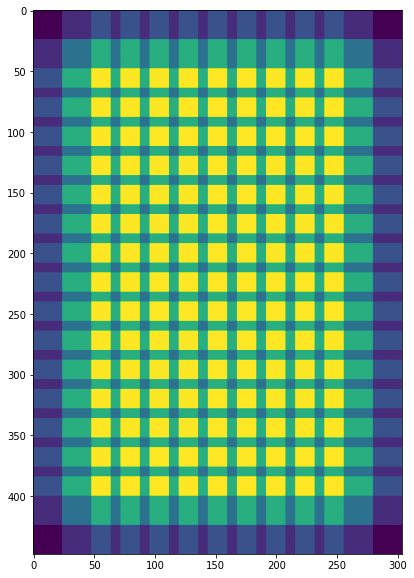

In [ ]:
# I will divide the collected predicted image by this pad
fig = plt.figure(figsize=(10, 10))
plt.imshow(images_pad)
fig.show()

In [ ]:
# same shape as the original image
images_pad.shape

(448, 304)

In [ ]:
x_test.shape

(12, 187, 5, 64, 64)

In [ ]:
model = tf.keras.models.load_model("convlstm_model6.h5")

In [ ]:
# for cropped image predicted, I will add the pixel values of the predicted image
# to the location it is dedicated
predicted_images = []

for j in range(12):
    image_predicted = np.zeros((448, 304))

    col_start = 0
    row_start = 0

    i = 0

    predicted_data = model.predict(x_test[j])

    while (row_start+crop_size) <= 448:
        col_start = 0
        while (col_start+crop_size) <= 304:
            rescaled_predicted_image = predicted_data[i] * 250
            image_predicted[row_start:row_start+crop_size, col_start:col_start+crop_size] += rescaled_predicted_image
            i += 1
            col_start += window_size
        row_start += window_size
    
    # here divide the collected image by the pad
    new_image = image_predicted / images_pad
    new_image = np.nan_to_num(new_image)
    predicted_images.append(new_image)


    

In [ ]:
predicted_images = np.array(predicted_images)

predicted_images.shape

(12, 448, 304)

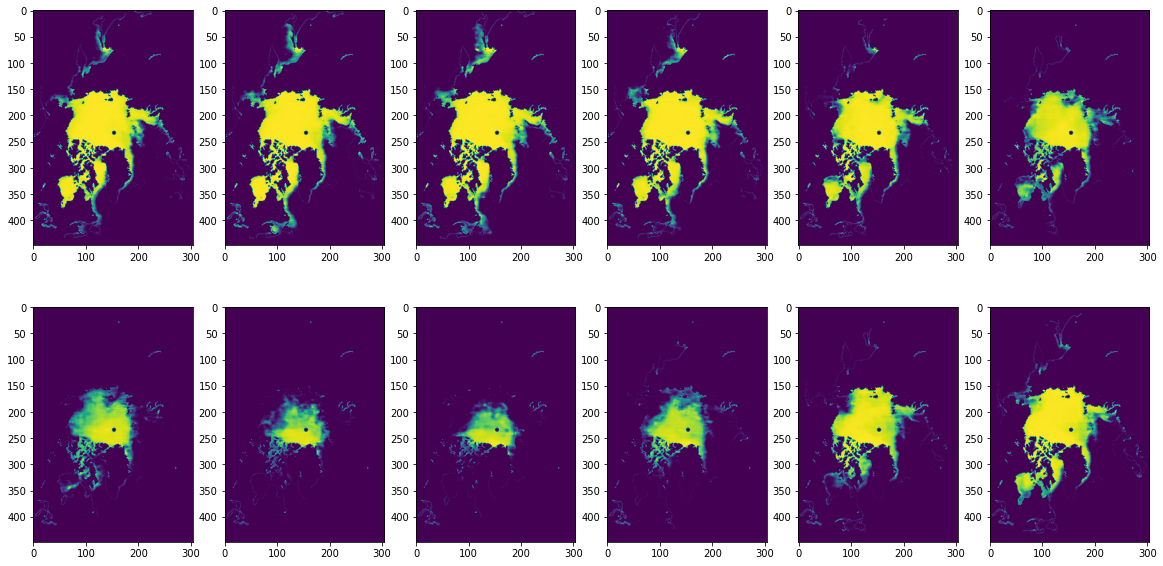

In [ ]:
# how the image looks
fig = plt.figure(figsize=(20, 10))
for i in range(12):
  fig.add_subplot(2, 6, i+1)
  plt.imshow(predicted_images[i])

fig.show()

## Submission

In [ ]:
sample_submission_df = pd.read_csv("sample_submission.csv")
sample_submission_df.head()

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_preds_df = []

for i in range(12):
  month_df = pd.DataFrame(data=predicted_images[i].reshape(1, -1))

  y_preds_df.append(month_df)

In [ ]:
concat_df = pd.concat(y_preds_df, axis=0)

In [ ]:
concat_df['month'] = sample_submission_df['month'].values[:12]
concat_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191,month
0,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,0.007089,...,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518,2019-01
0,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,0.007089,...,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518,2019-02
0,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,0.007089,...,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518,2019-03
0,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,0.007089,...,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518,2019-04
0,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,0.007089,...,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518,2019-05
0,0.004792,0.003

In [ ]:
df_month = sample_submission_df.iloc[:, 0]
submission_df = pd.merge(df_month, concat_df, on="month", how="left")

submission_df = submission_df.fillna(0)

In [ ]:
submission_df.to_csv("submission05.csv", index=False)

In [ ]:
pd.read_csv("submission05.csv")

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,...,0.00296,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518
1,2019-02,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,...,0.00296,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518
2,2019-03,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,...,0.00296,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518
3,2019-04,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,...,0.00296,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518
4,2019-05,0.004792,0.003158,0.005716,0.006252,0.007559,0.007827,0.007643,0.007503,0.007129,0.007679,0.007911,0.007359,0.007227,0.006452,0.007026,0.006049,0.005873,0.005728,0.005709,0.005636,0.00657,0.006467,0.005451,0.004896,0.004971,0.004773,0.00615,0.006877,0.007773,0.007974,0.007701,0.007578,0.0078,0.007954,0.007948,0.006902,0.007302,0.006923,0.007019,...,0.00296,0.003366,0.003278,0.003599,0.003762,0.003889,0.003869,0.003595,0.003489,0.003723,0.003202,0.002948,0.002419,0.002414,0.005379,0.00818,0.004016,0.004261,0.004299,0.003951,0.003814,0.004076,0.003874,0.003428,0.00355,0.003725,0.003416,0.003629,0.003712,0.00389,0.004041,0.003571,0.002991,0.003586,0.002624,0.002882,0.001384,0.001328,0.007448,0.012518
5,2019-06,0.00479